# The Overall Aim of this Notebook
This notebook explores the used-car dataset through interactive maps. They show the top five brands, the average sale price, and most popular fuel type in each city. These interactive visualizations bulid on the foundations of the main visualization notebook to further understanding of how location is related to car list price.

**Note:** These visualizations utilize interactive tooltips from the mplcursors package. For best results, we recommend viewing this notebook in Visual Studio Code or a JupyterLab environment capable of running Matplotlib backends. Otherwise, the plots will appear as static images. MP4 files of all three plots working as intended can be found in the "maps" folder of this repository. Each plot shows a map of India, and hovering the cursor over a city point should show data for each city (brands, sale price, or fuel type).

In [20]:
%matplotlib ipympl

import matplotlib
#matplotlib.use("TkAgg")
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.extra.rate_limiter import RateLimiter
import mplcursors

In [21]:
cars = pd.read_csv("Used_Car_Price_Prediction.csv")
cars.head(10)

,car_name,yr_mfr,fuel_type,kms_run,sale_price,city,times_viewed,body_type,transmission,variant,...,total_owners,broker_quote,original_price,car_rating,ad_created_on,fitness_certificate,emi_starts_from,booking_down_pymnt,reserved,warranty_avail
0,maruti swift,2015,petrol,8063,386399,noida,18715,hatchback,manual,lxi opt,...,2,397677,404177.0,great,2021-04-04T07:09:18.583,True,8975,57960,False,False
1,maruti alto 800,2016,petrol,23104,265499,noida,2676,hatchback,manual,lxi,...,1,272935,354313.0,great,2021-03-22T14:07:32.833,True,6167,39825,False,False
2,hyundai grand i10,2017,petrol,23402,477699,noida,609,hatchback,manual,sports 1.2 vtvt,...,1,469605,NaN,great,2021-03-20T05:36:31.311,True,11096,71655,False,False
3,maruti swift,2013,diesel,39124,307999,noida,6511,hatchback,manual,vdi,...,1,294262,374326.0,great,2021-01-21T12:59:19.299,True,7154,46200,False,False
4,hyundai grand i10,2015,petrol,22116,361499,noida,3225,hatchback,manual,magna 1.2 vtvt,...,1,360716,367216.0,great,2021-04-01T13:33:40.733,True,8397,54225,False,False
5,maruti alto k10,2018,petrol,23534,335299,noida,1055,hatchback,NaN,vxi (o) amt,...,1,343212,439056.0,great,2021-04-13T05:55:16.99,True,7788,50295,False,False
6,maruti ritz,2012,diesel,41213,281999,noida,909,hatchback,manual,vdi,...,1,201200,NaN,great,2020-12-29T07:26:25.321,True,6550,42300,False,False
7,hyundai i20,2012,petrol,38328,321499,noida,2760,hatchback,manual,asta 1.2,...,3,319200,410764.0,great,2021-02-25T15:47:30.3,True,7468,48225,False,False
8,hyundai elite i20,2014,diesel,56402,456199,noida,2475,hatchback,manual,magna 1.4 crdi,...,1,452023,566123.0,great,2021-03-13T11:57:25.71,True,10596,68430,False,False
9,renault kwid,2018,petrol,32703,281299,noida,2497,hatchback,manual,rxl,...,1,264597,344127.0,great,2021-03-20T06:52:56.488,True,6534,42195,False,False


## Missing Value Imputation

The following two code cells handle the missing data in **original price** column using KNN, and **transmission** column using data replacement.

In [22]:
imputer = KNNImputer(n_neighbors=5, weights='distance')
cars['original_price'] = imputer.fit_transform(cars[['original_price']])

In [23]:
cars['transmission'] = cars['transmission'].fillna('unknown')

## Pandas GeoData

First, we will geocode each of the 13 cities in the dataset and return their longitude and latitude values. The result is saved in a CSV file that is included in the repository.

In [24]:
geolocator = Nominatim(user_agent="city_mapper")

geocode = RateLimiter(
    geolocator.geocode,
    min_delay_seconds=3,       # at least 3 seconds between calls (per Nominatim policy)
    max_retries=2,             # retry a couple of times if it fails
    error_wait_seconds=3,      # wait 2 seconds before retrying after an error
    swallow_exceptions=False
)

def geocode_city(city, country="India"):
  location = geocode(f"{city}, {country}")
  if location:
    return location.latitude, location.longitude
  else:
    return None, None

cities = pd.DataFrame(cars["city"].astype('str').str.title().unique(), columns=["city"])
for idx, city in cities["city"].items():
    print(f"Geocoding: {city}...")
    lat, lon = geocode_city(city)
    cities.loc[idx, "lat"] = lat
    cities.loc[idx, "lon"] = lon

# Save geocoded cities
cities.to_csv("cities_geocoded_india.csv", index=False)

Geocoding: Noida...
Geocoding: Gurgaon...
Geocoding: Bengaluru...
Geocoding: New Delhi...
Geocoding: Mumbai...
Geocoding: Pune...
Geocoding: Hyderabad...
Geocoding: Chennai...
Geocoding: Kolkata...
Geocoding: Ahmedabad...
Geocoding: Faridabad...
Geocoding: Ghaziabad...
Geocoding: Lucknow...


Now, we can create a GeoDataFrame that includes latitude and longitude information for each city.   
In case the geocoding in the previous cell times out, the CSV file is read in with Pandas.    
Latitude and longitude values are converted into a shapely.geometry Point object.

In [25]:
# Optional: Read in geocoded cities
cities = pd.read_csv("cities_geocoded_india.csv")

# Create GeoData Frame
cars["city"] = cars["city"].astype("str").str.title()
df = pd.merge(cars, cities, how="outer", on="city")
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
map_cars = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

Now, we can load in a basic map of India. We downloaded the Natural Earth 110m dataset directly from naturalearthdatasets.com because it can no longer be done with GeoDataSets. The figure below shows a map of India with our cities plotted over it.

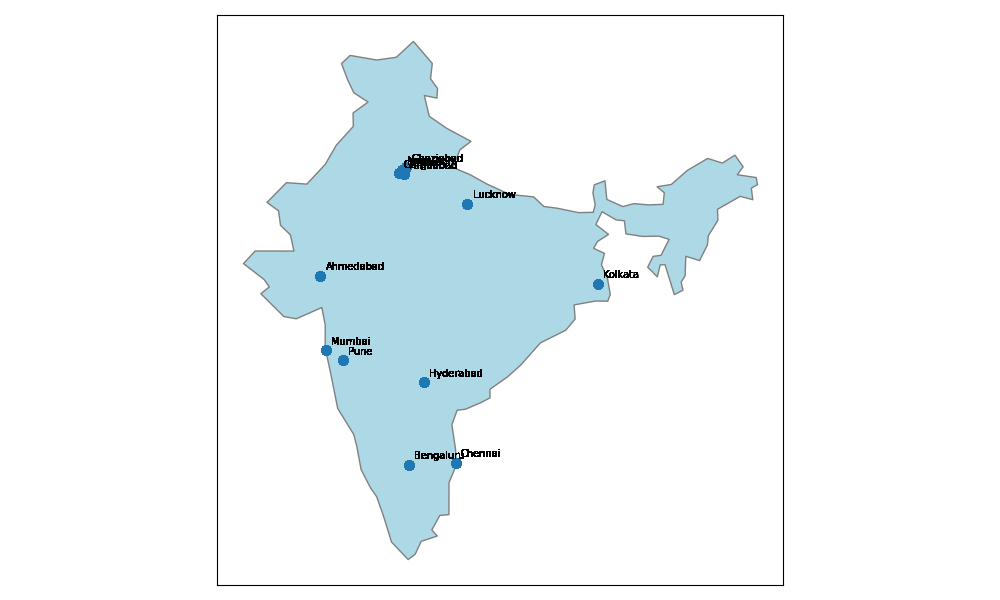

In [26]:
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world = world.set_crs("EPSG:4326")

# Extract India
india = world[world["ADMIN"] == "India"]

fig, ax = plt.subplots(figsize=(10, 6))

india.plot(ax=ax, color='lightblue', edgecolor='gray')
map_cars.plot(ax=ax, markersize=40)

for x, y, label in zip(map_cars.geometry.x, map_cars.geometry.y, map_cars["city"]):
  ax.text(x + 0.3, y + 0.3, label, fontsize=7)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

## Top Five Car Brands in Each City (interactive)

First we created a DataFrame that contains a list of the top 5 brands in each city and merged it into our main dataset, map_cars.

In [27]:
# Count brands per city
map_cars["brand"] = map_cars["car_name"].astype("str").str.split(" ").str[0].str.title()

top5_list = (
    map_cars.groupby(["city", "brand"]).size().groupby(level=0, group_keys=False)
    .nlargest(5).reset_index(name="count").groupby("city")["brand"].agg(list)
    .reset_index().rename(columns={"brand": "top5"})
)

map_cars = map_cars.merge(top5_list, on="city", how="left")

#### This interactive map shows the top five car brands in each city by hovering the cursor over each

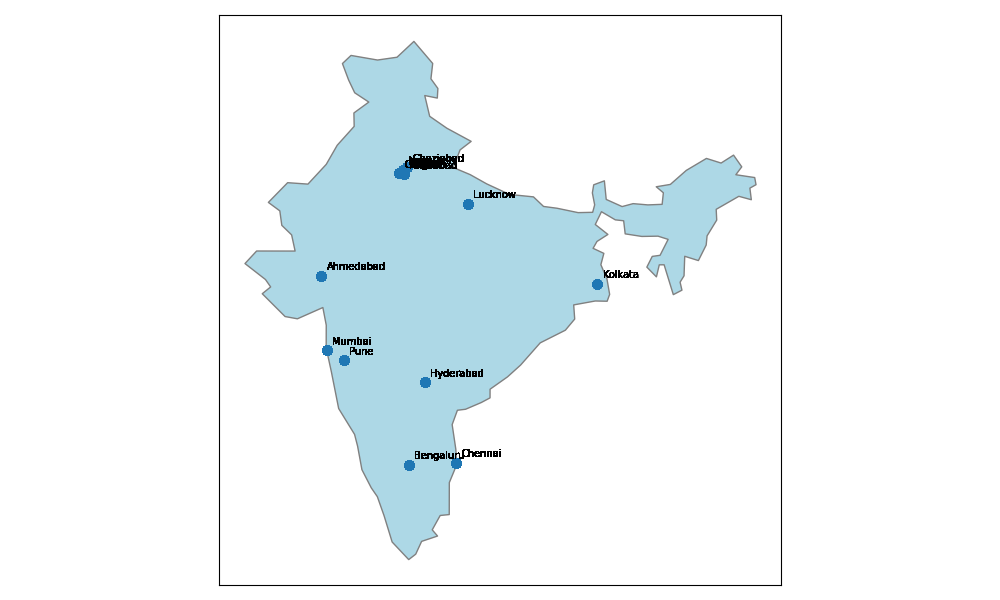

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

india.plot(ax=ax, color='lightblue', edgecolor='gray')
points = ax.scatter(map_cars.geometry.x, map_cars.geometry.y, s=40)


for x, y, label in zip(map_cars.geometry.x, map_cars.geometry.y, map_cars["city"]):
  ax.text(x + 0.3, y + 0.3, label, fontsize=7)

cursor = mplcursors.cursor(points, hover=True)
cursor.annotation_kwargs["animated"]  = False

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# An attempt to reduce tooltip lag
for c in ax.collections:
   if c is not points:
      c.set_picker(False)

@cursor.connect("add")
def on_add(sel):
  i = sel.index
  row = map_cars.iloc[i]

  brands = row["top5"]
  if isinstance(brands, list):
      brands_text = "\n".join(f"{j+1}. {b}" for j, b in enumerate(brands[:5]))
  else:
      brands_text = brands

  sel.annotation.set_text(
    f"{row['city']}\n\nTop Car Brands:\n{brands_text}"
  )


plt.tight_layout()
plt.show(block=False)

#### Insights from Top 5 Car Brands
- As shown in the heatmap in the main visualization notebook, the top brand in every city is Maruti.
- The second most popular brand in nearly every city is Hyundai.

The main purpose of this map is to visualize the information from the heatmap in an engaging, interactive way. We also learned that a few of our cities are quite close together, so making our maps interactive makes it easier to see the information.

## Average Sale Price in Each City

First, we must create a dataframe grouped by city that contains the average price in rupees and round the price to two decimal places. It is essential that the geometry is still in the dataframe after grouping, so instead of groupby(), we use the GeoData function dissolve(), which keeps it by default.

In [29]:
map2 = (map_cars.dissolve(by = "city", aggfunc = {"sale_price": "mean"}).reset_index())
map2["sale_price"] = map2["sale_price"].round(2)
map2.head()

,city,geometry,sale_price
0,Ahmedabad,POINT (72.58006 23.02154),471466.90
1,Bengaluru,POINT (77.59008 12.97679),466259.10
2,Chennai,POINT (80.27019 13.08369),493691.69
3,Faridabad,POINT (77.31056 28.40315),423068.74
4,Ghaziabad,POINT (77.4587 28.775),401728.94


#### This plot is a map that shows each city and the average sale price from car listings in that city.

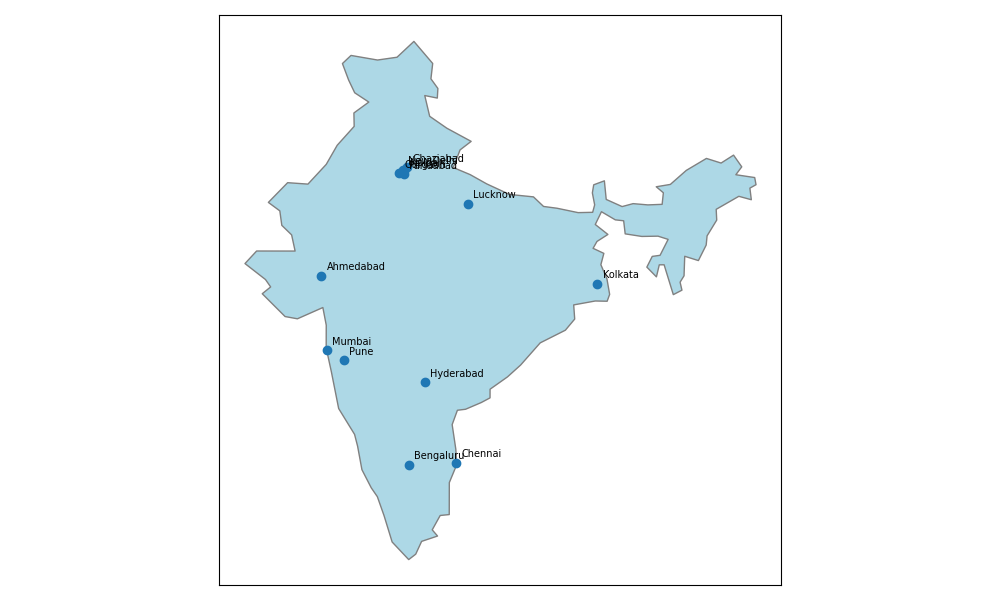

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

india.plot(ax=ax, color='lightblue', edgecolor='gray')
points = ax.scatter(
  map2.geometry.x,
  map2.geometry.y,
)

for x, y, label in zip(map2.geometry.x, map2.geometry.y, map2["city"]):
  ax.text(x + 0.3, y + 0.3, label, fontsize=7)

cursor = mplcursors.cursor(points, hover=True)
cursor.annotation_kwargs["animated"] = False

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for c in ax.collections:
  if c is not points:
    c.set_picker(False)

@cursor.connect("add")
def on_add(sel):
  i = sel.index
  row = map2.iloc[i]

  price = row["sale_price"]
  sel.annotation.set_text(f"{row['city']}\n\nAverage Sale Price:\n{price}")

plt.tight_layout();
plt.show(block=False);

#### Insights from Average Sale Price Map
- On average, most cars are priced above 400000, except in Kolkata.
- Location does not seem to have a significant impact on sale price. There could be other factors missing from our dataset that would make a potential relationship more clear.

## Most Popular Fuel Type in Each City

First, we must create a new GeoDataFrame that contains city name, the top fuel type, and the geometry. Because we are using the count of a categorical variable, we have to use groupby() instead of dissolve(). We must add the geometry back in from the dataset we used from the previous map. If the extraneous column "count" is not dropped, it is included in our figure as a line plot.

In [31]:
map3 = map_cars.groupby(["city", "fuel_type"]).size().reset_index(name = "count")
map3 = map3.sort_values(["city", "count"], ascending=True).groupby("city").first().reset_index()
map3["geometry"] = map2["geometry"]
map3 = map3.drop(columns="count")
map3 = gpd.GeoDataFrame(map3, geometry=map3["geometry"], crs="EPSG:4326")

In [32]:
cars["fuel_type"].unique()

array(['petrol', 'diesel', 'petrol & cng', 'electric', 'petrol & lpg'],
      dtype=object)

#### This plot shows the most popular fuel types in each city. The options are "Petrol", "Diesel", "Petrol & Cng", "Electric", and "Petrol & Lpg"

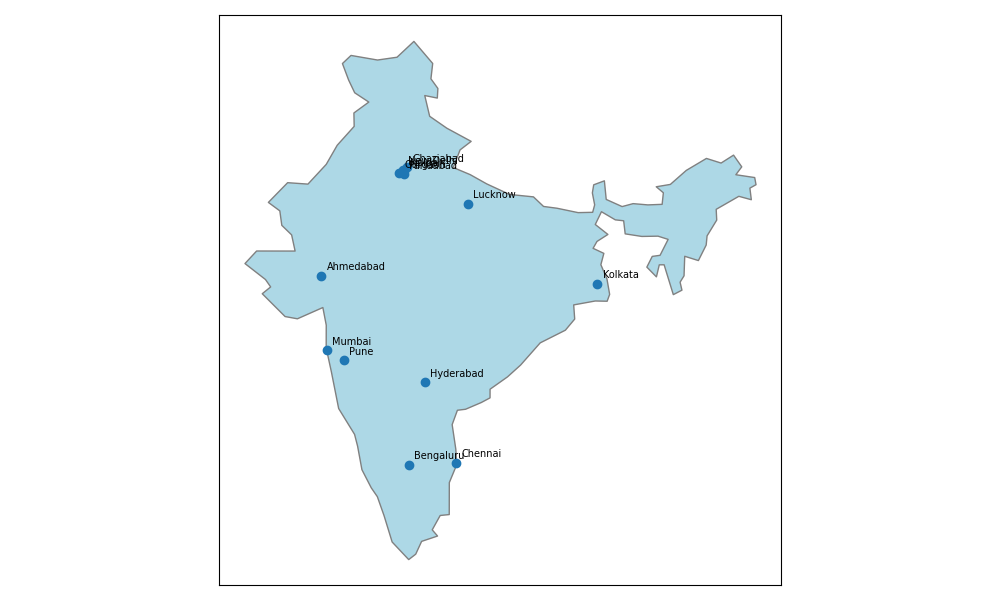

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

india.plot(ax=ax, color='lightblue', edgecolor='gray')
points = ax.scatter(
  map3.geometry.x,
  map3.geometry.y
)

for point, label in zip(map3.geometry, map3["city"]):
  ax.text(point.x + 0.3, point.y + 0.3, label, fontsize=7)

cursor = mplcursors.cursor(points, hover=True)
cursor.annotation_kwargs["animated"] = False

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for c in ax.collections:
  if c is not points:
    c.set_picker(False)

@cursor.connect("add")
def on_add(sel):
  i = sel.index
  row = map3.iloc[i]

  fuel = row["fuel_type"]
  sel.annotation.set_text(f"{row['city']}\n\nMost Popular Fuel Type:\n{fuel}")

plt.tight_layout();
plt.show(block=False);

#### Insights from Fuel Type Map
- In most cities, "Petrol and Lpg" or "Petrol and Cng" are the most popular.
- In Kolkata, "Diesel" is the most popular, while in Chennai and Bengaluru, "Electric" is the most popular.

## Conclusion

This notebook aimed to explore how geographic location is related to factors that affect car list prices. The purpose of creating interactive maps was to show some of the information from the main visualization notebook in a new way, and observe trends that might be easier to see on a map. Our goal for these plots is to present the data an an engaging and interactive way, and add to the foundation of the main visualization notebook.